# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import bipartite

In [ ]:
#pd.set_option('display.max_colwidth', None)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/RecSys/dataset/SinhVien.csv')
df.shape

(8800, 4)

In [ ]:
# Xóa dòng chứa bất kì 1 cell rỗng
for col in df.columns:
  df.drop(df[df[col] == 'blank'].index, inplace=True)
df.shape

(7405, 4)

In [ ]:
# Xóa dòng chứa email không có định dạng @gm.uit.edu.vn (email của giảng viên, cộng tác viên)
def get_MSSV(email):
  try:
    x=re.compile(r"(\d+)@gm\.uit\.edu\.vn")
    return x.search(email).group(1)
  except:
    return np.nan
df['MSSV'] = df['email'].apply(lambda email: get_MSSV(email))
print(df['MSSV'].isna().sum())
df.dropna(inplace=True)

161


In [ ]:
df['class'] = df['class'].str.replace("Mô tả sơ lược khoá học\n","")

In [ ]:
df.drop_duplicates(subset=['MSSV'], inplace=True)
df[df['MSSV'].duplicated(keep=False)]

,ID,name,email,class,MSSV


In [ ]:
# Những sinh viên có trên 1 dòng CVHT lớp...
# là những sinh viên chuyển ngành
# chỉ dữ lại ngành cuối cùng mà sinh viên học
df['So_Nganh_Hoc'] = df['class'].apply(lambda s: len(re.findall('(?=(CVHT lớp))', s)))
df['So_Nganh_Hoc'].value_counts()

1    6853
0     277
2     110
3       1
Name: So_Nganh_Hoc, dtype: int64

In [ ]:
# có 1 sinh viên học đến 3 ngành?
df[df['So_Nganh_Hoc']==3]

,ID,name,email,class,MSSV,So_Nganh_Hoc
2894,10894,Trần Đình Khang,18520896@gm.uit.edu.vn,CVHT lớp KHTN2018\nCVHT lớp KHMT2018\nCVHT lớp...,18520896,3


In [ ]:
def rm_Nganh_Hoc_Truoc(str1, num):
  if num==2:
    str2=str1.replace("CVHT lớp","",1)
    return str2
  if num==3:
    str2=str1.replace("CVHT lớp","",2)
    return str2
  return str1
df['class'] = df.apply(lambda x: rm_Nganh_Hoc_Truoc(x['class'], x['So_Nganh_Hoc']),axis=1)

In [ ]:
# ngành học của SV lấy từ "CVHT lớp..."
def get_NganhHoc(class1):
  try:
    x=re.compile(r"CVHT lớp (\w{4})")
    return x.search(class1).group(1)
  except:
    return np.nan
df['Nganh_Hoc'] = df['class'].apply(lambda str1: get_NganhHoc(str1))
df.head()

,ID,name,email,class,MSSV,So_Nganh_Hoc,Nganh_Hoc
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL
2,8002,LÊ DUY CHÍ CƯỜNG,16520141@gm.uit.edu.vn,Các cuộc thi của Đoàn Thanh niên,16520141,0,NaN
3,8003,PHAN TRUNG NGUYÊN,16520851@gm.uit.edu.vn,CVHT lớp CNTT2016\nCác cuộc thi của Đoàn Thanh...,16520851,1,CNTT
4,8004,NGUYỄN MINH HẢI,16520330@gm.uit.edu.vn,CVHT lớp HTCL2016.1\nCác cuộc thi của Đoàn Tha...,16520330,1,HTCL


In [ ]:
df1=df.assign(Ten_Lop=df['class'].str.split('\n')).explode('Ten_Lop')
df1[['Ten_Lop']].head(10)

,Ten_Lop
0,CVHT lớp KTPM2016
0,Các cuộc thi của Đoàn Thanh niên
0,Sinh hoạt Công dân Sinh viên - Năm học 2021-2022
0,Thực tập tốt nghiệp - SE501.L11
0,Nhập môn phát triển game - SE102.L11
0,Chuyên đề J2EE - SE325.K21
0,Đồ án chuyên ngành - SE112.K21
0,Nhập môn phát triển game - SE102.K21
0,Quản lý dự án công nghệ thông tin - IS208.K21
0,Lập trình trên thiết bị di động - SE346.K11


In [ ]:
def get_MaMH (Ten_Lop):
  try:
    x=re.compile(r"- (\w+)\.")
    return x.search(Ten_Lop).group(1)
  except:
    return np.nan
df1['Ma_MH'] = df1['Ten_Lop'].apply(lambda Ten_Lop: get_MaMH(Ten_Lop))
df1.head()

,ID,name,email,class,MSSV,So_Nganh_Hoc,Nganh_Hoc,Ten_Lop,Ma_MH
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM,CVHT lớp KTPM2016,NaN
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM,Các cuộc thi của Đoàn Thanh niên,NaN
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM,Sinh hoạt Công dân Sinh viên - Năm học 2021-2022,NaN
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM,Thực tập tốt nghiệp - SE501.L11,SE501
0,8000,NGUYỄN CAO LUYỆN,16520713@gm.uit.edu.vn,CVHT lớp KTPM2016\nCác cuộc thi của Đoàn Thanh...,16520713,1,KTPM,Nhập môn phát triển game - SE102.L11,SE102


In [ ]:
def get_Loai_Lop(Ten_Lop):
  try:
    x=re.compile(r"- \w+.\w+.(\w+)")
    return x.search(Ten_Lop).group(1)
  except:
    return np.nan
df1['Loai_Lop'] = df1['Ten_Lop'].apply(lambda MH: get_Loai_Lop(MH))

In [ ]:
def get_Ma_Nam_Hoc(Ten_Lop):
  try:
    x=re.compile(r"\.(\w+)\.")
    return x.search(Ten_Lop).group(1)
  except:
    return np.nan
df1['Ma_Nam_Hoc'] = df1['Ten_Lop'].apply(lambda MH: get_Ma_Nam_Hoc(MH))

In [ ]:
df1.dropna(subset=['Ma_MH','Ma_Nam_Hoc','Loai_Lop'], inplace=True)
df1.shape

(109419, 11)

In [ ]:
# Xóa lớp của chương trình tiên tiến, liên kết,...
list_CTTT = ["IEM","CSBU","CNBU"]
def rm_CTTT(Ma_MH):
  for CTTT in list_CTTT:
    if CTTT in str(Ma_MH):
      return np.nan
  return Ma_MH
df1['Ma_MH']=df1['Ma_MH'].apply(lambda mh: rm_CTTT(mh))
df1.dropna(subset=["Ma_MH"], inplace=True)
df1.shape

(108968, 11)

In [ ]:
# Xóa những môn bắt buộc (IT, MA, SS,...)
keep_list = ['SE','CS','IS','IE','CE','NT','EC','DS']
def filter_keep_list(Ma_MH):
  if Ma_MH[0:2] in keep_list:
    return Ma_MH
  return np.nan
df1['Ma_MH']=df1['Ma_MH'].apply(lambda mh: filter_keep_list(mh))
df1.dropna(subset=["Ma_MH"], inplace=True)
df1.drop(df1[df1['Loai_Lop']=="CTTT"].index, inplace=True)
df1.shape

(55270, 11)

In [ ]:
df1.sample(5)

,ID,name,email,class,MSSV,So_Nganh_Hoc,Nganh_Hoc,Ten_Lop,Ma_MH,Loai_Lop,Ma_Nam_Hoc
6402,15402,Nguyễn Trí Vũ,20521042@gm.uit.edu.vn,CVHT lớp CNT22020\nMA004 - Cấu trúc rời rạc\nI...,20521042,1,CNT2,Khai thác dữ liệu truyền thông xã hội - IE403....,IE403,VB2,N11
7320,16320,Nguyễn Thúc Bảo,21520617@gm.uit.edu.vn,CVHT lớp PMCL2021.1\nMA003 - Đại số tuyến tính...,21520617,1,PMCL,Nhập môn Công nghệ phần mềm - SE104.N24.CLC,SE104,CLC,N24
5427,13427,Nguyễn Phan Nhật Quang,19522095@gm.uit.edu.vn,SS006 - Pháp luật đại cương\nIT007 - Hệ điều h...,19522095,0,NaN,Thiết kế hệ thống số với HDL - CE213.M13.MTCL,CE213,MTCL,M13
3104,11104,Đoàn Văn Nghĩa,18521139@gm.uit.edu.vn,CVHT lớp MTCL2018.2\nCác cuộc thi của Đoàn Tha...,18521139,1,MTCL,Thiết kế vi mạch số - CE222.L22.MTCL,CE222,MTCL,L22
4898,12898,Nguyễn Trung Hiếu,19521508@gm.uit.edu.vn,CVHT lớp PMCL2019.2\nSS006 - Pháp luật đại cươ...,19521508,1,PMCL,Nhập môn Công nghệ phần mềm - SE104.L22.PMCL,SE104,PMCL,L22


In [ ]:
df1['2_char_Ma_MH']=df1['Ma_MH'].str[0:2]
df1['2_char_Ma_MH'].value_counts()

NT    14728
SE    11222
CS     8266
IS     7386
CE     6202
IE     4519
EC     2614
DS      333
Name: 2_char_Ma_MH, dtype: int64

In [ ]:
df1[df1['2_char_Ma_MH']=='NT']['Loai_Lop'].value_counts()

MMCL    4379
ANTT    4290
ATCL    3904
ANTN    1820
HTCL     274
VB2       39
ATTT      22
Name: Loai_Lop, dtype: int64

In [ ]:
df1['Nganh_Hoc']=df1['Nganh_Hoc'].str.replace("KHDL","DL",regex=False)

In [ ]:
df1['2_char_Nganh_Hoc']=df1['Nganh_Hoc'].str[0:2]

In [ ]:
df1["2_char_Nganh_Hoc"]=df1["2_char_Nganh_Hoc"].str.replace("KT","MT",regex=False)

In [ ]:
df1['2_char_Nganh_Hoc'].value_counts()

PM    10566
AT     9545
KH     8254
MT     7157
HT     6615
MM     4996
CN     4243
TM     2953
DL       74
Name: 2_char_Nganh_Hoc, dtype: int64

In [ ]:
df1['Nam_Nhap_Hoc'] ="20" + df1['MSSV'].str[0:2]
df1['Nam_Nhap_Hoc'].value_counts()

2019    13986
2020    13946
2018    10039
2017     7883
2021     5036
2016     4380
Name: Nam_Nhap_Hoc, dtype: int64

In [ ]:
df1['Loai_Lop'].value_counts()

PMCL    10485
HTCL     6885
KHCL     6612
MTCL     5478
CNCL     4535
MMCL     4379
ANTT     4316
ATCL     3904
TMCL     3497
ANTN     1836
KHTN     1799
VB2       501
1         373
2         232
CLC       185
3          85
tử         70
4          39
5          32
ATTT       22
CNVN        5
Name: Loai_Lop, dtype: int64

In [ ]:
temp_list = ["1","2","3","5"]
def temp_func(x):
  if x in temp_list:
    return "DaiTra"
  else:
    return x
df1['Loai_Lop'] = df1['Loai_Lop'].apply(lambda x :temp_func(x))

In [ ]:
df1['Ma_Nam_Hoc_1'] = df1['Ma_Nam_Hoc'].str[0]
df1['Ma_Nam_Hoc_1'].value_counts()

M    14120
N    13891
L    10811
K     7342
O     5962
J     3144
Name: Ma_Nam_Hoc_1, dtype: int64

In [ ]:
df1['learned']=1

In [ ]:
df1.drop_duplicates(subset=['MSSV','Ma_MH'],inplace=True)
df1.head()

,ID,name,email,class,MSSV,So_Nganh_Hoc,Nganh_Hoc,Ten_Lop,Ma_MH,Loai_Lop,Ma_Nam_Hoc,2_char_Ma_MH,2_char_Nganh_Hoc,Nam_Nhap_Hoc,Ma_Nam_Hoc_1,learned
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL,Khai thác dữ liệu - IS252.K11.HTCL,IS252,HTCL,K11,IS,HT,2016,K,1
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL,Kho dữ liệu và OLAP - IS217.K11.HTCL,IS217,HTCL,K11,IS,HT,2016,K,1
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL,Cơ sở dữ liệu phân tán - IS211.K11.HTCL,IS211,HTCL,K11,IS,HT,2016,K,1
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL,Phát triển ứng dụng trên thiết bị di động - NT...,NT118,HTCL,K12,NT,HT,2016,K,1
1,8001,VŨ VIỆT HOÀNG,16521508@gm.uit.edu.vn,CVHT lớp HTCL2016.2\nCác cuộc thi của Đoàn Tha...,16521508,1,HTCL,Phân tích dữ liệu kinh doanh - IS403.J22.HTCL,IS403,HTCL,J22,IS,HT,2016,J,1


In [ ]:
Nganh_Hoc_mapping = {"PM":"SE",
                     "KH":"CS",
                     "HT":"IS",
                     "CN":"IE",
                     "MT":"CE",
                     "MM":"NT",
                     "AT":"NT",
                     "TM":"EC",
                     "DL":"DS"}
df1["Nganh_Hoc_mapping"] = df1['2_char_Nganh_Hoc'].map(Nganh_Hoc_mapping)

In [ ]:
# Lấy những dòng có Mã ngành học của sinh viên != Mã ngành của lớp => môn tự chọn
df_diff = df1.loc[df1['2_char_Ma_MH'] !=df1['Nganh_Hoc_mapping']]

In [ ]:
df_diff.shape

(7575, 17)

# Elective subjects

In [ ]:
df_graph = df_diff.copy()
df_graph.shape

(7575, 17)

In [ ]:
def plot_hist(df):
  count = df.groupby('MSSV')['Ma_MH'].count()
  sns.histplot(count)

In [ ]:
num_subject = df_graph.groupby(['Ma_MH', 'MSSV']).size().groupby('Ma_MH').size()
print('# So luong mon hoc: %d' % len(num_subject))
num_subject_with_enough_interactions = num_subject[num_subject >5] \
.reset_index()[['Ma_MH']]
print('# So luong mon hoc co it nhat 5 sinh vien: %d' % len(num_subject_with_enough_interactions))

# So luong mon hoc: 182
# So luong mon hoc co it nhat 5 sinh vien: 125


In [ ]:
num_student = df_graph.groupby(['MSSV', 'Ma_MH']).size().groupby('MSSV').size()
print('# So luong sinh vien: %d' % len(num_student))
num_student_with_enough_interaction = num_student[num_student <=8] \
.reset_index()[['MSSV']]
print('# So luong sinh vien hoc it nhat 5 mon: %d' % len(num_student_with_enough_interaction))

# So luong sinh vien: 2601
# So luong sinh vien hoc it nhat 5 mon: 2498


In [ ]:
df_graph=df_graph.merge(num_subject_with_enough_interactions, how='right',left_on='Ma_MH',right_on='Ma_MH')
df_graph=df_graph.merge(num_student_with_enough_interaction, how='right',left_on='MSSV',right_on='MSSV')
df_graph.dropna(subset=['MSSV','Ma_MH'], inplace=True)
print(df_graph.shape)
print(df_graph['Ma_MH'].nunique())
df_graph['MSSV'].nunique()

(6064, 17)
121


2483

In [ ]:
df_graph.head(3)

,ID,name,email,class,MSSV,So_Nganh_Hoc,Nganh_Hoc,Ten_Lop,Ma_MH,Loai_Lop,Ma_Nam_Hoc,2_char_Ma_MH,2_char_Nganh_Hoc,Nam_Nhap_Hoc,Ma_Nam_Hoc_1,learned,Nganh_Hoc_mapping
0,8139.0,NGUYỂN LÊ HOÀI ÂN,16520011@gm.uit.edu.vn,CVHT lớp PMCL2016.1\nCác cuộc thi của Đoàn Tha...,16520011,1.0,PMCL,Phân tích thiết kế hệ thống thông tin - IS201....,IS201,PMCL,J23,IS,PM,2016,J,1.0,SE
1,8366.0,NGUYỄN TRẦN THIÊN ÂN,16520013@gm.uit.edu.vn,CVHT lớp ATTT2016\nCác cuộc thi của Đoàn Thanh...,16520013,1.0,ATTT,Phương pháp luận nghiên cứu khoa học - CS519.J...,CS519,ANTT,J21,CS,AT,2016,J,1.0,NT
2,8173.0,PHAN HOÀNG ÂN,16520017@gm.uit.edu.vn,CVHT lớp KHMT2016.1\nCác cuộc thi của Đoàn Tha...,16520017,1.0,KHMT,Máy học và các công cụ - SE355.O11.PMCL,SE355,PMCL,O11,SE,KH,2016,O,1.0,CS


In [ ]:
df_test=df_graph.groupby("Nganh_Hoc_mapping").sample(frac=0.12)
df_graph.drop(df_test.index, inplace=True)

In [ ]:
Ma_MH_test_list = set(df_test['Ma_MH'])
Ma_MH_train_list = set(df_graph['Ma_MH'])
inter_list = Ma_MH_test_list.intersection(Ma_MH_train_list)
df_redundant = df_test[~df_test['Ma_MH'].isin(inter_list)]
df_test = df_test[df_test['Ma_MH'].isin(inter_list)]
df_graph = pd.concat([df_graph, df_redundant])

In [ ]:
MSSV_test_list = set(df_test['MSSV'])
MSSV_train_list = set(df_graph['MSSV'])
inter_list = MSSV_test_list.intersection(MSSV_train_list)
df_redundant = df_test[~df_test['MSSV'].isin(inter_list)]
df_test = df_test[df_test['MSSV'].isin(inter_list)]
df_graph = pd.concat([df_graph, df_redundant])

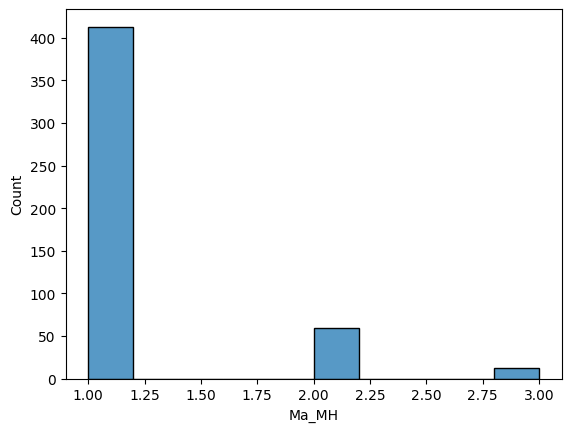

In [ ]:
plot_hist(df_test)

In [ ]:
df_graph.to_csv('/content/drive/MyDrive/RecSys/dataset/df_graph.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/RecSys/dataset/df_test.csv', index=False)

In [2]:
df_graph=pd.read_csv('/content/drive/MyDrive/RecSys/dataset/df_graph.csv')
df_test = pd.read_csv('/content/drive/MyDrive/RecSys/dataset/df_test.csv')

# Graph

In [ ]:
pip install node2vec -qq

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
#from node2vec import Node2Vec
from gensim.models import KeyedVectors

In [ ]:
B=nx.Graph()
SinhVien = df_graph['MSSV']
MonHoc = df_graph['Ma_MH']
for index, row in df_graph.iterrows():
  B.add_edge(row['MSSV'],row['Ma_MH'],weight=1)
B.add_nodes_from(MonHoc, bipartite = 0)
B.add_nodes_from(SinhVien, bipartite = 1)

In [ ]:
node2vec_B = Node2Vec(B, dimensions=32, walk_length=10, num_walks=100, workers=4)

Computing transition probabilities:   0%|          | 0/2604 [00:00<?, ?it/s]

In [ ]:
B_embedded = node2vec_B.fit(window=10, min_count=1, batch_words=4)

In [ ]:
#Store just the words + their trained embeddings.
word_vectors = B_embedded.wv
word_vectors.save("/content/drive/MyDrive/RecSys/model_embedding/node2vec.wordvectors")

In [4]:
#Load back with memory-mapping = read-only, shared across processes.
B_embedded = KeyedVectors.load("/content/drive/MyDrive/RecSys/model_embedding/node2vec.wordvectors", mmap='r')

In [5]:
node_embeddings = {node_id: B_embedded[node_id] for node_id in B_embedded.index_to_key}

In [6]:
def get_rated_items(user_id):
  return set(df_graph[df_graph['MSSV'] == user_id]['Ma_MH'])

In [7]:
def get_user_embedding_graph(user_id):
    embeddings = node_embeddings
    return embeddings[str(user_id)]

In [8]:
def calculate_similarities_graph(user_id):

    df=df_graph
    embeddings=node_embeddings
    user_id = str(user_id)

    rated_items = get_rated_items(user_id)
    user_embedding = get_user_embedding_graph(user_id)

    item_similarities = []
    for item_id in set(df['Ma_MH']):
        if item_id not in rated_items:
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities

In [9]:
def recommend_items_graph(user_id, num_items=5):

  item_similarities = calculate_similarities_graph(user_id)
  recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]
  recommended_items_df = pd.DataFrame(recommended_items, columns=['Ma_MH','cosine_similarity'])
  return recommended_items_df

In [10]:
a=recommend_items_graph(16520198)
a

,Ma_MH,cosine_similarity
0,EC001,0.737051
1,IS208,0.649615
2,EC005,0.564294
3,IS334,0.546909
4,NT402,0.495938


# Content-Based

In [ ]:
pip install -U sentence-transformers -qq

In [ ]:
from sentence_transformers import SentenceTransformer
SBert = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
df_Content_MH =pd.read_csv('/content/drive/MyDrive/RecSys/dataset/ChiTietMonHoc.csv')

In [ ]:
X_Content_MH = df_Content_MH['Tên MH'] + " " + df_Content_MH['Tóm tắt môn học']
bad_chars = [';', ',', ':', ".", '▪','–','/','(',')','-','•','\r','...']
for i in bad_chars:
    X_Content_MH = X_Content_MH.str.replace(i, ' ', regex=False)
X_Content_MH[:5]

0    Hệ thống thông tin kế toán Trình bày các kiến ...
1    Hoạch định nguồn lực doanh nghiệp Cung cấp cho...
2    Giới thiệu ngành Kỹ Thuật Máy tính Hiều biết r...
3    Vi xử lý vi điều khiển   Môn học sẽ cung cấp c...
4    Xử lý tín hiệu số Môn học Xử lý tín hiệu số nh...
dtype: object

<Axes: ylabel='Count'>

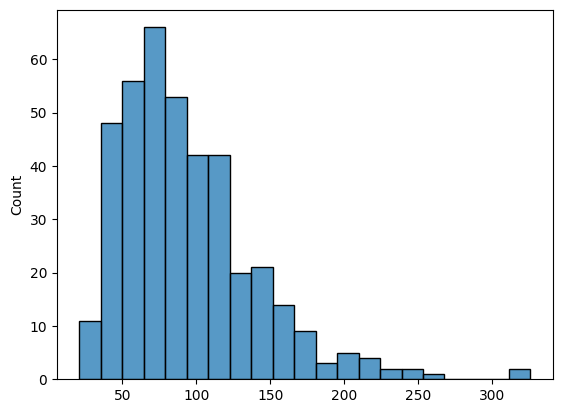

In [ ]:
import seaborn as sns
count = X_Content_MH.str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
sns.histplot(count)

In [ ]:
MH_Content_embeddings = SBert.encode(X_Content_MH)

In [ ]:
len(MH_Content_embeddings)

401

In [ ]:
np.save("/content/drive/MyDrive/RecSys/model_embedding/MH_Content_embeddings.npy",MH_Content_embeddings)

In [ ]:
MH_Content_embeddings = np.load("/content/drive/MyDrive/RecSys/model_embedding/MH_Content_embeddings.npy")

In [ ]:
tuples_MH = [(key, value)
          for i, (key, value) in enumerate(zip(list(df_Content_MH['Mã MH']), MH_Content_embeddings))]
dict_MH = dict(tuples_MH)

In [ ]:
df_join = df_graph.merge(df_Content_MH, how='left',left_on='Ma_MH',right_on='Mã MH')

In [ ]:
df_join=df_join[['MSSV','Ma_MH','Tên MH','Tóm tắt môn học']]

In [ ]:
df_join['Tóm tắt môn học']=df_join['Tóm tắt môn học'].fillna('')
df_join['Tên MH']=df_join['Tên MH'].fillna('')

In [ ]:
MSSV_profile = df_join.groupby('MSSV')[['Tóm tắt môn học','Tên MH']].agg(lambda x: ', '.join(x)).reset_index()
MSSV_profile

,MSSV,Tóm tắt môn học,Tên MH
0,16520011,Môn học trình bày các khái niệm và phương pháp...,Phân tích thiết kế hệ thống thông tin
1,16520013,Môn học hướng về việc trang bị cho sinh viên n...,Phương pháp luận nghiên cứu khoa học
2,16520017,,
3,16520021,Môn học trình bày các khái niệm và phương pháp...,Phân tích thiết kế hệ thống thông tin
4,16520045,Trang bị cho sinh viên những kiến thức và kỹ n...,Phát triển ứng dụng trên thiết bị di động
...,...,...,...
2478,21522764,,
2479,21522780,Giúp cho học viên có được kiến thức và kỹ năng...,Quản trị bán hàng
2480,21522794,"Môn học giới thiệu tổng quan về khái niệm, đặc...",Công nghệ Dữ liệu lớn
2481,21522797,Môn học cung cấp một số kiến thức trong việc t...,Phân tích và thiết kế thuật toán


In [ ]:
X_Content_MSSV = MSSV_profile['Tên MH'] + " " + MSSV_profile['Tóm tắt môn học']
bad_chars = [';', ':','▪','–','/','(',')','-','•','\r','...']
for i in bad_chars:
    X_Content_MSSV = X_Content_MSSV.str.replace(i, ' ', regex=False)

<Axes: ylabel='Count'>

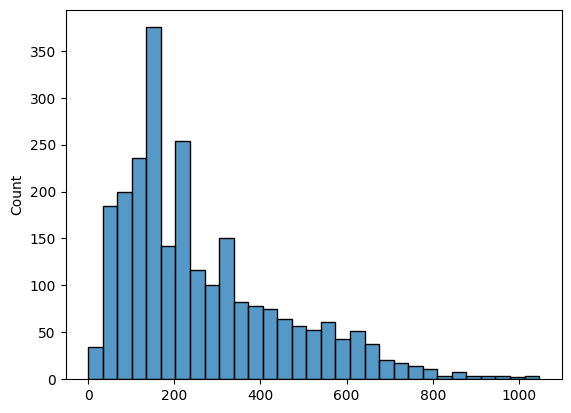

In [ ]:
import seaborn as sns
count = X_Content_MSSV.str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
sns.histplot(count)

In [ ]:
MSSV_Content_embeddings = SBert.encode(X_Content_MSSV)

In [ ]:
len(MSSV_Content_embeddings)

2483

In [ ]:
np.save("/content/drive/MyDrive/RecSys/model_embedding/MSSV_Content_embeddings.npy",MSSV_Content_embeddings)

In [ ]:
MSSV_Content_embeddings=np.load("/content/drive/MyDrive/RecSys/model_embedding/MSSV_Content_embeddings.npy")

In [ ]:
tuples_SV = [(key, value)
          for i, (key, value) in enumerate(zip(list(MSSV_profile['MSSV']), MSSV_Content_embeddings))]
dict_SV = dict(tuples_SV)

In [ ]:
def get_MSSV_embedding(user_id):
  embeddings = dict_SV
  return embeddings[user_id]

In [ ]:
def get_MH_embedding(user_id):
  embeddings = dict_MH
  return embeddings[user_id]

In [ ]:
def calculate_similarities_CB(user_id):
    df=df_graph
    embeddings=dict_SV
    rated_items = get_rated_items(user_id)
    user_embedding = get_MSSV_embedding(user_id)

    item_similarities = []
    for item_id in set(df['Ma_MH']):
        if item_id not in rated_items:
          try:
            item_embedding = get_MH_embedding(item_id)
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))
          except:
            item_similarities.append((item_id, 0))

    return item_similarities

In [ ]:
def recommend_items_CB(user_id, num_items=5):
    item_similarities = calculate_similarities_CB(user_id)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]
    recommended_items_df = pd.DataFrame(recommended_items, columns = ['Ma_MH','cosine_similarity'])
    return recommended_items_df


In [ ]:
recommend_items_CB(16520198)

,Ma_MH,cosine_similarity
0,EC208,0.982960
1,CS519,0.976184
2,NT137,0.975722
3,NT207,0.974285
4,SE114,0.973951


# Colabborative Filtering

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = df_graph.pivot(index='MSSV',
                                                          columns='Ma_MH',
                                                          values='learned').fillna(0)

users_items_pivot_matrix_df

Ma_MH,CE005,CE119,CE121,CE124,CS105,CS106,CS110,CS111,CS112,CS114,...,SE313,SE330,SE331,SE347,SE350,SE355,SE357,SE358,SE401,SE405
MSSV,,,,,,,,,,,,,,,,,,,,,
16520011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16520013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16520017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16520021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16520045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21522764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21522780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21522794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[16520011,
 16520013,
 16520017,
 16520021,
 16520045,
 16520054,
 16520056,
 16520061,
 16520063,
 16520074]

In [ ]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<2483x121 sparse matrix of type '<class 'numpy.float64'>'
	with 5495 stored elements in Compressed Sparse Row format>

In [ ]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 30
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
U.shape

(2483, 30)

In [ ]:
Vt.shape

(30, 121)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(30, 30)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 2.96402370e-06,  2.09644517e-03,  1.23444079e-04, ...,
        -2.45428263e-03,  2.37385226e-04,  9.25382278e-04],
       [-3.76411372e-04, -3.58944442e-03, -2.71867269e-03, ...,
        -1.92740874e-03, -3.80112139e-04,  9.89877715e-04],
       [-1.85523426e-05, -1.29018067e-04,  1.04321002e-04, ...,
        -8.91812002e-04, -2.76468775e-05, -2.51950441e-04],
       ...,
       [ 4.28578254e-05, -4.34667340e-03,  6.30572088e-04, ...,
        -2.70927430e-03,  5.82251899e-04, -1.23119301e-03],
       [ 2.76184351e-04, -2.14404083e-03, -2.47367116e-03, ...,
        -1.07581738e-03,  7.80471258e-05,  4.21914983e-03],
       [-2.22193266e-04,  2.00780726e-03,  3.49589858e-03, ...,
        -1.00816590e-02, -7.32508875e-04,  3.08719207e-04]])

In [ ]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) \
/ (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,16520011,16520013,16520017,16520021,16520045,16520054,16520056,16520061,16520063,16520074,...,21522655,21522664,21522703,21522723,21522734,21522764,21522780,21522794,21522797,21522821
Ma_MH,,,,,,,,,,,,,,,,,,,,,
CE005,0.199442,0.199241,0.199430,0.199442,0.198825,0.199241,0.198819,0.198916,0.198306,0.204571,...,0.199486,0.199234,0.199586,0.198690,0.199519,0.199557,0.199781,0.199463,0.199586,0.199322
CE119,0.200550,0.197539,0.199372,0.200550,0.196901,0.197539,0.198578,0.198655,0.196914,0.203581,...,0.199447,0.199532,0.198304,0.198950,0.201040,0.199380,0.198936,0.197138,0.198304,0.200503
CE121,0.199505,0.198000,0.199495,0.199505,0.204323,0.198000,0.205359,0.199322,0.197760,0.199103,...,0.199464,0.199398,0.198130,0.201048,0.201553,0.199428,0.197441,0.199774,0.198130,0.201292
CE124,0.199266,0.199306,0.199377,0.199266,0.200969,0.199306,0.200356,0.199034,0.198670,0.199070,...,0.199430,0.199705,0.199114,0.199048,0.199461,0.199437,0.199264,0.198595,0.199114,0.199442
CS105,0.194351,0.200543,0.199304,0.194351,0.202419,0.200543,0.192589,0.202082,0.203441,0.203879,...,0.199611,0.199457,0.204729,0.193788,0.205643,0.199642,0.197514,0.195652,0.204729,0.205733
CS106,0.199748,0.215809,0.199026,0.199748,0.197038,0.215809,0.201751,0.204745,0.202385,0.202655,...,0.199664,0.198832,0.200861,0.201305,0.210621,0.199226,0.195516,0.190962,0.200861,0.211048
CS110,0.199489,0.199776,0.199474,0.199489,0.198928,0.199776,0.199412,0.199279,0.199149,0.199597,...,0.199427,0.199464,0.200753,0.199430,0.199538,0.199428,0.199581,0.200192,0.200753,0.199521
CS111,0.196296,0.198504,0.199270,0.196296,0.201044,0.198504,0.198873,0.208211,0.212366,0.208234,...,0.199434,0.199703,0.203720,0.201717,0.198254,0.199427,0.198938,0.198145,0.203720,0.198319
CS112,0.200831,0.201780,0.201040,0.200831,0.189136,0.201780,0.198914,0.194402,0.190805,0.197054,...,0.199572,0.200964,0.246407,0.195383,0.198457,0.199005,0.199806,0.247868,0.246407,0.197946


In [ ]:
cf_preds_df.to_csv('/content/drive/MyDrive/RecSys/model_embedding/cf_preds_df.csv')

In [ ]:
cf_preds_df = pd.read_csv('/content/drive/MyDrive/RecSys/model_embedding/cf_preds_df.csv')
cf_preds_df.set_index('Ma_MH', inplace=True)

In [ ]:
def recommend_items_CF(user_id, num_items=5):
    df=cf_preds_df
    user_id = str(user_id)

    rated_items = get_rated_items(user_id)

    item_similarities = cf_preds_df[user_id].drop(labels=rated_items) \
                        .sort_values(ascending = False).head(num_items)

    item_similarities_df = pd.DataFrame(item_similarities)
    item_similarities_df.reset_index(inplace=True)
    item_similarities_df.columns = ['Ma_MH','cosine_similarity']
    return item_similarities_df


In [ ]:
b=recommend_items_CF(16520198)
b

,Ma_MH,cosine_similarity
0,IS208,0.725071
1,IS334,0.708442
2,EC001,0.665843
3,EC003,0.273672
4,IE212,0.252747


# Hybrid

In [ ]:
def recommend_items_hybrid(user_id, num_items = 5):
  CB_pred = recommend_items_CB(user_id)
  CF_pred = recommend_items_CF(user_id)
  graph_pred = recommend_items_graph(user_id)

  CB_pred['cosine_similarity'] = CB_pred['cosine_similarity']/10
  CF_pred['cosine_similarity'] = CF_pred['cosine_similarity']/2
  # concat recommneded items of all model
  df_concat = pd.concat([CB_pred,CF_pred,graph_pred])

  # if a subject is recommended by more model, it will have higher weight
  temp1=df_concat['Ma_MH'].value_counts().rename_axis('Ma_MH').reset_index(name='counts')
  temp2=temp1.merge(df_concat, how='left',on='Ma_MH')
  temp3=temp2.groupby("Ma_MH")['cosine_similarity'].sum()
  temp4=temp3.rename_axis('Ma_MH').reset_index(name='cosine_similarity')
  temp5=temp4.sort_values(by='cosine_similarity',ascending=False)
  min_temp5 = temp5['cosine_similarity'].min()
  max_temp5 = temp5['cosine_similarity'].max()
  temp5['cosine_similarity'] = (temp5['cosine_similarity']-min_temp5)/(max_temp5-min_temp5)
  df_mixed = temp5.head(num_items)


  return df_mixed

In [ ]:
recommend_items_hybrid(16520198)

,Ma_MH,cosine_similarity
1,EC001,1.000000
6,IS208,0.940548
7,IS334,0.826397
3,EC005,0.480064
10,NT402,0.409780


# Evaluate

In [11]:
from statistics import mean

In [12]:
def evaluate(pred_list,true_list, k):
  pred_list = list(pred_list)
  true_list = list(true_list)

  TP=0
  for item in pred_list[0:k+1]:
    if(item) in true_list:
      TP+=1
  if TP == 0:
    return [0,0,0]

  precision_at_k = TP/k
  recall_at_k = TP/len(true_list)
  f1_at_k = (2*precision_at_k*recall_at_k)/(precision_at_k+recall_at_k)

  return precision_at_k, recall_at_k, f1_at_k

In [13]:
def evaluate_at_k(rec_model, k):
  mean_precision_at_k = []
  mean_recall_at_k = []
  mean_f1_at_k = []
  for MSSV in set(df_test['MSSV']):

    rec_items=rec_model(MSSV,num_items=k)
    rec_items_list = rec_items['Ma_MH']
    true_list = df_test[df_test['MSSV']==MSSV]['Ma_MH']

    precision, recall, f1 = evaluate(rec_items_list,true_list, k)
    mean_precision_at_k.append(precision)
    mean_recall_at_k.append(recall)
    mean_f1_at_k.append(f1)


  return mean(mean_precision_at_k), mean(mean_recall_at_k), mean(mean_f1_at_k)

In [14]:
evaluate_at_k(recommend_items_graph, 5)

(0.03505154639175258, 0.15463917525773196, 0.05633284241531665)

In [ ]:
list_k = list(range(1, 21))
list_k = list_k +[30, 50]
list_rec = [recommend_items_CB, recommend_items_CF, recommend_items_graph, recommend_items_hybrid]
model = []
k_value = []
global_precsion_at_k = []
global_recall_at_k = []
global_f1_at_k = []
for k in list_k:
  for rec_model in list_rec:

    model.append(rec_model.__name__)
    k_value.append(k)

    precison_temp, recall_temp, f1_temp = evaluate_at_k(rec_model, k)
    global_precsion_at_k.append(precison_temp)
    global_recall_at_k.append(recall_temp)
    global_f1_at_k.append(f1_temp)

compare_mapping={'model_name': model,
                 'k': k_value,
                 'P@k': global_precsion_at_k,
                 'R@k': global_recall_at_k,
                 "f1@k": global_f1_at_k}
df_compare_model = pd.DataFrame(compare_mapping)

In [ ]:
col = ['P@k','R@k','f1@k']
df_compare_model[col] = df_compare_model[col].round(5)
df_compare_model

,model_name,k,P@k,R@k,f1@k
0,recommend_items_CB,1,0.01031,0.00825,0.00893
1,recommend_items_CF,1,0.00825,0.00619,0.00687
2,recommend_items_graph,1,0.00000,0.00000,0.00000
3,recommend_items_hybrid,1,0.00000,0.00000,0.00000
4,recommend_items_CB,2,0.01134,0.01718,0.01320
...,...,...,...,...,...
83,recommend_items_hybrid,30,0.01024,0.26598,0.01963
84,recommend_items_CB,50,0.01184,0.50447,0.02305
85,recommend_items_CF,50,0.01509,0.65533,0.02942
86,recommend_items_graph,50,0.01802,0.75670,0.03508


In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df_compare_model.to_csv("/content/drive/MyDrive/RecSys/model_embedding/df_compare_model.csv", index=False)

<Axes: xlabel='k', ylabel='P@k'>

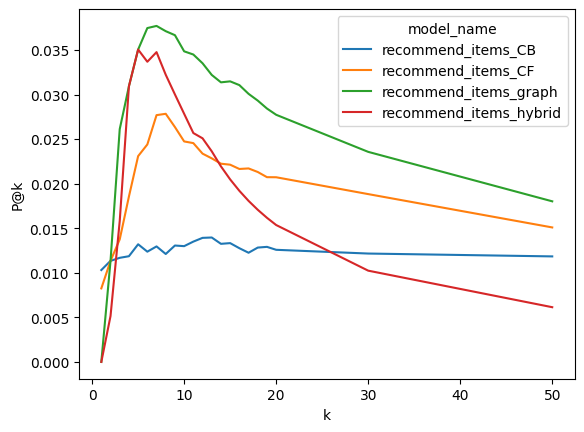

In [ ]:
sns.lineplot(data=df_compare_model, x='k', y='P@k',hue='model_name')

<Axes: xlabel='k', ylabel='R@k'>

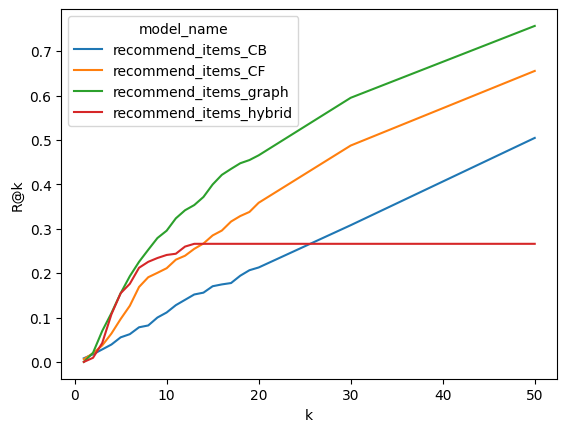

In [ ]:
sns.lineplot(data=df_compare_model, x='k', y='R@k',hue='model_name')

<Axes: xlabel='k', ylabel='f1@k'>

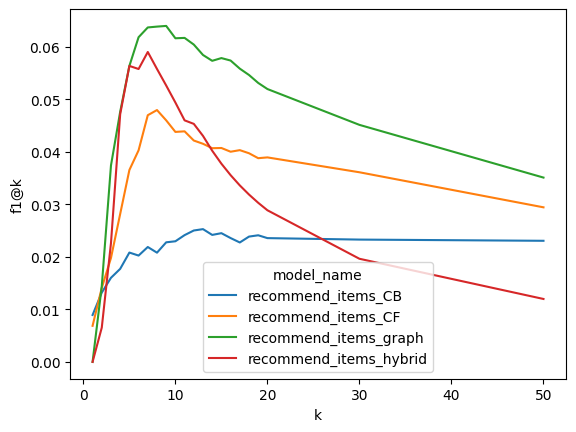

In [ ]:
sns.lineplot(data=df_compare_model, x='k', y='f1@k',hue='model_name')